In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from skyfield.api import load, Topos
from scipy.optimize import newton
planets = load('de423.bsp')

In [172]:
class plutino:
    """
    generate plutinos
    units: au, radius
    
    """
    def __init__(self):
        self.size = 10000
        self.lambda_N = 0
        self.a = self.gen_a()
        self.e = self.gen_e()
        self.i = self.gen_i()
        self.amp = self.gen_amp()
        self.phi = self.gen_phi(self.amp)
        self.M = self.gen_M()
        self.node = self.gen_node()
        self.arg = self.gen_arg(self.phi, self.M, self.node, self.lambda_N)
        self.H = self.gen_H()
        cut = self.e > 0
        print cut.sum()
        self.a = self.a[cut]
        self.e = self.e[cut]
        self.i = self.i[cut]
        self.amp = self.amp[cut]
        self.phi = self.phi[cut]
        self.M = self.M[cut]
        self.node = self.node[cut]
        self.arg = self.arg[cut]
        self.H = self.H[cut]       
        self.X, self.Y, self.Z, self.E, self.v = zip(*map(self.kep_to_xyz, self.a, self.e, self.i, self.arg, self.node, self.M))
    
    def gen_a(self):
        return 39.45 + np.random.random(self.size) * 0.4 - 0.2
        
    def gen_e(self):
        return np.random.normal(loc=0.175, scale=0.06, size = self.size)
        
    def gen_i(self):
        return np.arcsin(np.random.rayleigh(scale = 12 * np.pi/180., size = self.size))
        
    def gen_amp(self):
        return np.random.triangular(0, 5, 10, size = self.size) * np.pi / 180.
    
    def gen_phi(self, amp):
        return np.pi + amp * np.sin(2*np.pi*np.random.random(self.size))
        
    def gen_M(self):
        return 4*np.pi*np.random.random(self.size)
        
    def gen_node(self):
        return 2*np.pi*np.random.random(self.size)
        
    def gen_arg(self, phi, M, node, lambda_N):
        return (0.5*phi - 1.5*M - node + lambda_N) % (2*np.pi)
        
    def gen_H(self):
        alpha = 0.9
        h0 = 0
        h1 = 10
        h0s10 = 10**(alpha*h0)
        h1s10 = 10**(alpha*h1)
        return np.log10(np.random.random(self.size)*(h1s10-h0s10) + h0s10) / alpha
        
    def kep_to_xyz(self, a, e, i, arg, node, M):
        #print a, e, i, arg, node, M
        # compute eccentric anomaly
        f = lambda E, M, e: E - e * np.sin(E) - M
        E0 = M
        E = newton(f, E0, args=(M, e))
        # compute true anomaly
        v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
        # compute the radius
        r = a * (1 - e * np.cos(E))
        # compute X,Y,Z
        X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
        Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
        Z = r * (np.sin(i) * np.sin(arg + v))
        return X, Y, Z, E, v
        
    def xyz_to_equa(self, X, Y, Z):
        dec = np.arcsin(Z/(X**2+Y**2+Z**2)**0.5)
        ra = np.arctan2(Y, X)

In [173]:
p = plutino()
print p.arg.max(), p.arg.min()
print p.M.max(), p.M.min()
print p.node.max(), p.node.min()
print max(p.E), min(p.E)
print max(p.v), min(p.v)
print (np.array(p.v)+p.arg).max(), (np.array(p.v)+p.arg).min()

9981
6.281612691331036 0.0004393127040653866
12.566050268240803 0.0028061937264004704
6.283092824089949 0.00023670235320941792
12.565975886752081 0.0033077851194158133
6.2826246416933555 -6.282557069255553
12.513002762780895 -6.189716160454512


(array([354., 416., 471., 564., 649., 724., 611., 458., 363., 357., 355.,
        386., 451., 575., 696., 681., 578., 516., 409., 367.]),
 array([-6.28255707e+00, -5.65429798e+00, -5.02603890e+00, -4.39777981e+00,
        -3.76952073e+00, -3.14126164e+00, -2.51300256e+00, -1.88474347e+00,
        -1.25648438e+00, -6.28225299e-01,  3.37862189e-05,  6.28292872e-01,
         1.25655196e+00,  1.88481104e+00,  2.51307013e+00,  3.14132921e+00,
         3.76958830e+00,  4.39784739e+00,  5.02610647e+00,  5.65436556e+00,
         6.28262464e+00]),
 <a list of 20 Patch objects>)

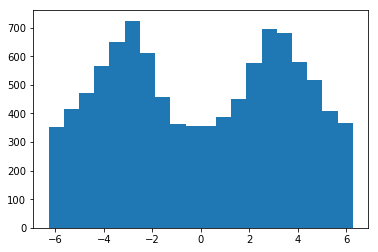

In [178]:
plt.hist(p.v, bins=20)

(array([ 623., 1502., 1943., 1875., 1565., 1100.,  630.,  374.,  184.,
         106.,   53.,   12.,    7.,    2.,    3.,    0.,    0.,    0.,
           0.,    2.]),
 array([ 0.16808261,  4.23343483,  8.29878706, 12.36413928, 16.4294915 ,
        20.49484372, 24.56019594, 28.62554816, 32.69090039, 36.75625261,
        40.82160483, 44.88695705, 48.95230927, 53.01766149, 57.08301372,
        61.14836594, 65.21371816, 69.27907038, 73.3444226 , 77.40977482,
        81.47512705]),
 <a list of 20 Patch objects>)

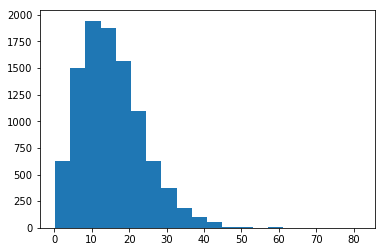

In [179]:
plt.hist(p.i*180/np.pi, bins=20)

(array([3.800e+01, 8.800e+01, 1.780e+02, 3.200e+02, 5.950e+02, 8.730e+02,
        1.175e+03, 1.275e+03, 1.392e+03, 1.263e+03, 1.037e+03, 7.370e+02,
        4.670e+02, 2.850e+02, 1.410e+02, 7.000e+01, 2.500e+01, 1.600e+01,
        5.000e+00, 1.000e+00]),
 array([0.0008448 , 0.02175021, 0.04265561, 0.06356102, 0.08446642,
        0.10537183, 0.12627723, 0.14718264, 0.16808804, 0.18899345,
        0.20989885, 0.23080426, 0.25170966, 0.27261507, 0.29352047,
        0.31442588, 0.33533128, 0.35623669, 0.37714209, 0.3980475 ,
        0.4189529 ]),
 <a list of 20 Patch objects>)

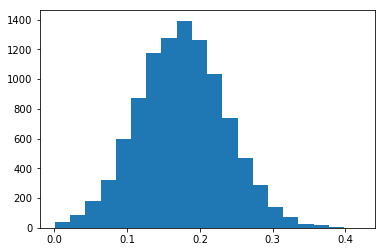

In [180]:
plt.hist(p.e, bins=20)

(array([503., 508., 528., 499., 499., 474., 492., 523., 520., 481., 490.,
        464., 517., 523., 499., 490., 508., 466., 469., 528.]),
 array([39.25001847, 39.27001165, 39.29000483, 39.30999801, 39.32999118,
        39.34998436, 39.36997754, 39.38997071, 39.40996389, 39.42995707,
        39.44995025, 39.46994342, 39.4899366 , 39.50992978, 39.52992295,
        39.54991613, 39.56990931, 39.58990248, 39.60989566, 39.62988884,
        39.64988202]),
 <a list of 20 Patch objects>)

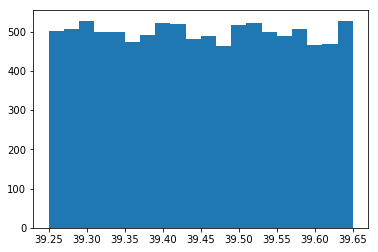

In [181]:
plt.hist(p.a, bins=20)

(array([ 72., 171., 243., 323., 442., 529., 642., 720., 868., 962., 956.,
        780., 710., 625., 579., 480., 396., 247., 161.,  75.]),
 array([0.02792434, 0.52370606, 1.01948778, 1.5152695 , 2.01105122,
        2.50683294, 3.00261466, 3.49839638, 3.9941781 , 4.48995982,
        4.98574154, 5.48152326, 5.97730498, 6.4730867 , 6.96886842,
        7.46465014, 7.96043186, 8.45621358, 8.9519953 , 9.44777702,
        9.94355874]),
 <a list of 20 Patch objects>)

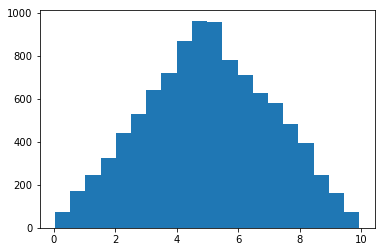

In [182]:
plt.hist(p.amp*180/np.pi, bins=20)

(array([ 36., 112., 205., 318., 493., 652., 749., 788., 843., 895., 872.,
        847., 757., 729., 640., 443., 320., 168.,  89.,  25.]),
 array([2.97283724, 2.98992721, 3.00701719, 3.02410716, 3.04119713,
        3.05828711, 3.07537708, 3.09246706, 3.10955703, 3.126647  ,
        3.14373698, 3.16082695, 3.17791693, 3.1950069 , 3.21209688,
        3.22918685, 3.24627682, 3.2633668 , 3.28045677, 3.29754675,
        3.31463672]),
 <a list of 20 Patch objects>)

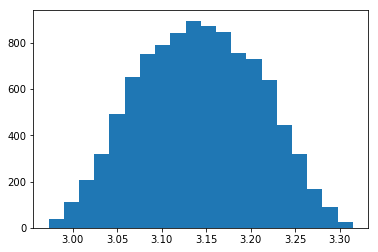

In [183]:
plt.hist(p.phi, bins=20)

(array([1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        6.000e+00, 9.000e+00, 1.800e+01, 2.600e+01, 3.400e+01, 5.000e+01,
        1.060e+02, 1.920e+02, 3.300e+02, 5.430e+02, 8.600e+02, 1.436e+03,
        2.374e+03, 3.992e+03]),
 array([5.16149941, 5.40342402, 5.64534863, 5.88727324, 6.12919785,
        6.37112246, 6.61304707, 6.85497168, 7.09689629, 7.3388209 ,
        7.58074551, 7.82267012, 8.06459473, 8.30651934, 8.54844394,
        8.79036855, 9.03229316, 9.27421777, 9.51614238, 9.75806699,
        9.9999916 ]),
 <a list of 20 Patch objects>)

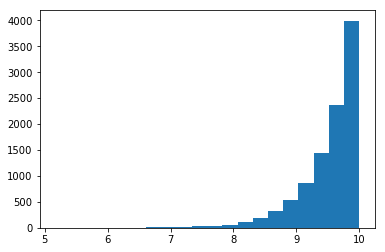

In [184]:
#plt.yscale('log')
plt.hist(p.H, bins=20)

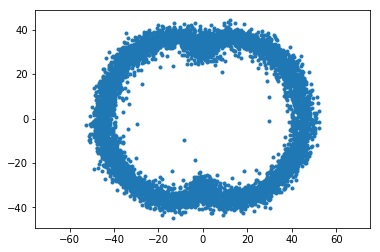

In [185]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')

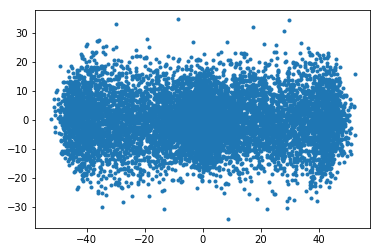

In [186]:
plt.axis('equal')
plt.plot(p.X,p.Z, '.')

In [187]:
def kep_to_xyz(a, e, i, arg, node, M):
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    r = a * (1 - e * np.cos(E))
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z   

In [148]:
a =100+np.zeros(100)
e = 0.7+np.zeros(100)
i = np.pi/10. +np.zeros(100)
arg =  np.pi/10.+np.zeros(100)
node =  np.pi/10.+np.zeros(100)
M = np.arange(0, 2*np.pi, 2*np.pi/100.)

In [149]:
x, y, z = zip(*map(kep_to_xyz, a, e, i, arg, node, M))

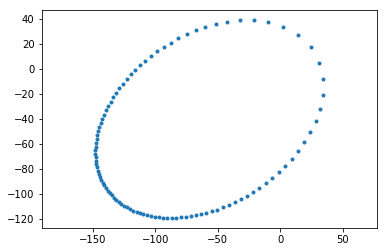

In [150]:
plt.axis('equal')
plt.scatter(x, y, marker = '.')